In [1]:
import numpy as np
import pandas as pd
import random as rand
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hep_ml import reweight

In [2]:
#MC data
mc_data_dict = np.load('data_comb/mc_data.npy', allow_pickle=True)[()]
feature1 = mc_data_dict['mass']
feature2 = mc_data_dict['pT']
feature_name= ["mass", "pT"]
data_2d = np.column_stack((feature1, feature2))
train_data, test_data = train_test_split(data_2d, test_size=0.5, random_state=42)

In [3]:
#real data
real_data_dict = np.load('data_comb/unmix_data.npy', allow_pickle=True)[()]
feature1 = real_data_dict['mass']
feature2 = real_data_dict['pT']
real_data_2d = np.column_stack((feature1, feature2))

Due to the limitation of the detector modeling in simulation and for not considering some effects, upon applying the event selections to both reconstructed events in the data and the Monte Carlo (MC) simulations, it's possible for discrepancies to arise between the real data and the MC. Here, we present a straightforward example using 2D, but this can be extended to include more dimensions of interest.

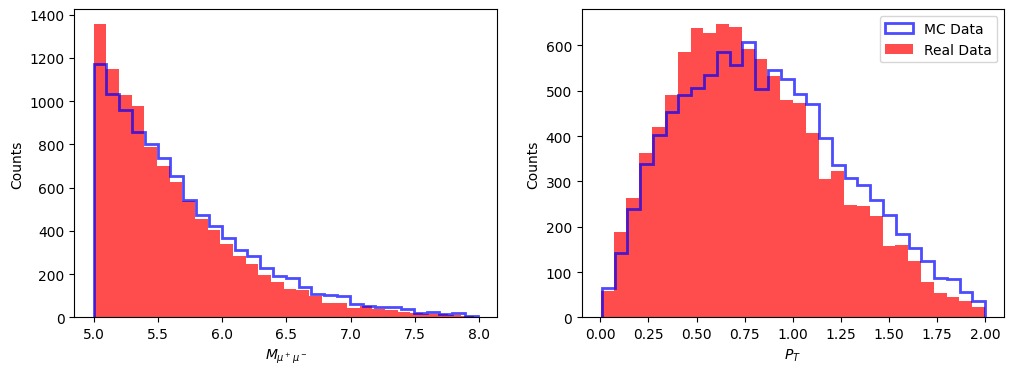

In [35]:
#draw how different the distributions are
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_data[:10000, 0], bins=30, color='b', alpha=0.7, label='MC Data', histtype='step', linewidth=2)
plt.hist(real_data_2d[:10000, 0], bins=30, color='red', alpha=0.7, label='Real Data')
plt.xlabel('$M_{\mu^+ \mu^-}$')
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
plt.hist(train_data[:10000, 1], bins=30, color='b', alpha=0.7, label='MC Data', histtype='step', linewidth=2)
plt.hist(real_data_2d[:10000, 1], bins=30, color='r', alpha=0.7, label='Real Data')
plt.xlabel('$^{}P_T$')
plt.ylabel('Counts')
plt.legend()

In [5]:
print("real data:  ",real_data_2d.shape[0] )
print("mc data:  ",train_data.shape[0] )

real data:   355676
mc data:   1190361


Now, we plan to use the multidimensional features in the `GBReweighter` and obtain the predicted MC weights. For now, we are going to use other default hyperparameters, with `n_estimators=100`. However, it is possible to tune other parameters to achieve better results. Detailed information about the reweighting method can be found in the paper: [arXiv:1608.05806](https://arxiv.org/abs/1608.05806).


In [6]:
# Train the reweighting model
reweighter = reweight.GBReweighter(n_estimators=100)
# reweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.1, max_depth=3, min_samples_leaf=1000,
#                                    gb_args={'subsample': 0.4})
# reweighter.fit(train_data[:, :2], real_data_2d[:, :2])
min_events = min(train_data.shape[0], real_data_2d.shape[0])
reweighter.fit(train_data[:min_events, :2], real_data_2d[:min_events, :2])
# Apply the reweighting to the test simulated mc data
weights_test_data = reweighter.predict_weights(test_data)

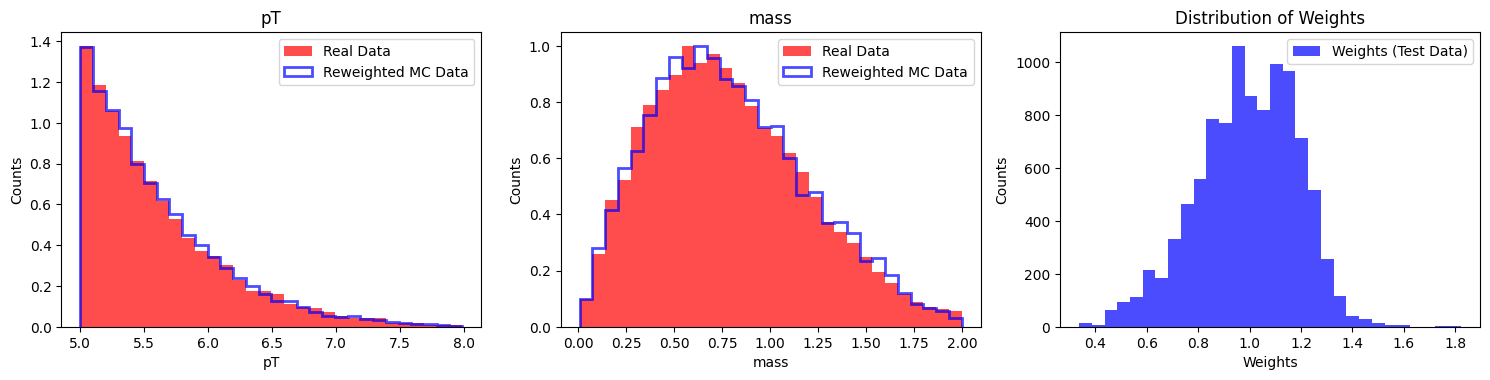

In [30]:
hist_settings = {'bins': 30, 'density': True, 'alpha': 0.7}

def draw_distributions_with_weights(original, target, weights_test_data):
    plt.figure(figsize=[15, 7])
    
    # Define the columns
    columns = ['pT', 'mass']
    
    for id, column in enumerate(columns, 1):
        column_index = id - 1   
        xlim = np.percentile(np.hstack([target[:, column_index]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[:, column_index][:10000], range=xlim, **hist_settings, color='r', label='Real Data', weights=weights_test_data[:10000])
        plt.hist(target[:10000, column_index], range=xlim, **hist_settings, color='blue', label='Reweighted MC Data', histtype='step', linewidth=2)
        plt.title(column)
        plt.xlabel(column)   
        plt.ylabel('Counts')  
        plt.legend()
    plt.subplot(2, 3, 3)
    plt.hist(weights_test_data[:10000], bins=30, color='blue', alpha=0.7, label='Weights (Test Data)')
    plt.title('Distribution of Weights')
    plt.xlabel('Weights')
    plt.ylabel('Counts')
    plt.legend()

    plt.tight_layout()
    plt.show()

draw_distributions_with_weights(test_data, real_data_2d, weights_test_data)


# KS = Kolmogorov-Smirnov distance: Lower is better. 

In [28]:
from hep_ml.metrics_utils import ks_2samp_weighted

def compute_and_print_ks(original, target, weights, num_events=10000):
    for id, column in enumerate(['pT', 'mass'], 1):
        column_index = id - 1  
        ks_stat = ks_2samp_weighted(original[:num_events, column_index], target[:num_events, column_index],
                                    weights1=weights[:num_events], weights2=np.ones(num_events, dtype=float))
        print(f'KS over {column} = {ks_stat}')
compute_and_print_ks(test_data, real_data_2d, weights_test_data, num_events=10000)


KS over pT = 0.010415588791418962
KS over mass = 0.009090162893613751
